# Multi Layer Perceptron
A feed forward neural network with multiple layers and each layer having dense connections.

## Problem: MNIST Digit Classification

### Model
![alt text](images/MLP.png "Title")

### Layer Diagram
![alt text](images/LayerDiag.png "Title")


#### Reading Dataset $\rightarrow$ Building Computational Graph (Model) $\rightarrow$ Define Loss and Optimizer $\rightarrow$ Training (Forward$\rightarrow$Backward$\rightarrow$Parameter update) $\rightarrow$ Testing

### Reading Dataset

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.init as weight_init
import matplotlib.pyplot as plt
import pdb

preprocess = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

#Loading the train set file
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=preprocess,  
                            download=True)
#Loading the test set file
test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=preprocess)

print(len(train_dataset))
print(train_dataset[0][0].size())

#Plotting
plt.figure()
plt.axis('off')
plt.imshow(train_dataset[110][0].squeeze(),cmap='gray')

0it [00:00, ?it/s]

100%|█████████▉| 9871360/9912422 [02:29<00:00, 78488.74it/s] 

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 115039.40it/s]
32768it [00:00, 101059.44it/s]                           

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:23, 69102.30it/s]

  2%|▏         | 40960/1648877 [00:00<00:20, 78527.66it/s]

  6%|▌         | 98304/1648877 [00:00<00:15, 100131.18it/s]

 11%|█         | 180224/1648877 [00:01<00:11, 128633.27it/s]

 16%|█▋        | 270336/1648877 [00:01<00:09, 146243.75it/s]

 20%|██        | 335872/1648877 [00:01<00:06, 189953.11it/s]

 28%|██▊       | 466944/1648877 [00:01<00:04, 255122.47it/s]

 34%|███▍      | 565248/1648877 [00:02<00:04, 236214.10it/s]

 44%|████▍     | 729088/1648877 [00:02<00:03, 293532.75it/s]

 49%|████▊     | 802816/1648877 [00:02<00:02, 353507.04it/s]

 54%|█████▎    | 884736/1648877 [00:03<00:02, 264206.91it/s]

 58%|█████▊    | 950272/1648877 [00:03<00:02, 301571.95it/s]

 63%|██████▎   | 1040384/1648877 [00:03<00:01, 365230.12it/s]

 67%|██████▋   | 1097728/1648877 [00:03<00:01, 334875.51it/s]

 70%|██████▉   | 1146880/1648877 [00:03<00:01, 338939.81it/s]

 73%|███████▎  | 1196032/

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




8192it [00:00, 17310.72it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
60000
torch.Size([1, 28, 28])


9920512it [02:40, 78488.74it/s]                             
32768it [00:20, 101059.44it/s]

### Defining DataLoader
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

X_train: torch.Size([100, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([100]) type: torch.LongTensor


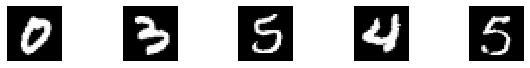

In [2]:
# Dataloader
batch_size = 100

#loading the train dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

#loading the test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

#Plotting 10 digits
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")

In [3]:
# Parameters 
input_size = 784
hidden_size = 256
num_classes = 10
num_epochs = 25
learning_rate = 0.01
momentum_rate = 0.9

### Building Model

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
        #Weight Initialization
        for m in self.modules():
          if isinstance(m,nn.Linear):
            weight_init.xavier_normal_(m.weight)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

net = Net(input_size, hidden_size, num_classes)

#Other functions
def loss_plot(losses):
    max_epochs = len(losses)
    times = list(range(1, max_epochs+1))
    plt.figure(figsize=(30, 7))
    plt.xlabel("epochs")
    plt.ylabel("cross-entropy loss")
    return plt.plot(times, losses)

### Defining Loss

In [5]:
#Loss function
criterion = nn.CrossEntropyLoss()

### Defining Optimizer

In [6]:
# SGD for Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum_rate)

##RMSProp
# torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
##Adam
# torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
##Adagrad
# torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)

### Training Loop

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using CUDA ', use_cuda)

#Transfer to GPU device if available
net = net.to(device)
net

# Training
epochLoss = []
for epoch in range(num_epochs):
    
    total_loss = 0
    cntr = 1
    # For each batch of images in train set
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 28*28)
        labels = labels
        
        images, labels = images.to(device), labels.to(device)
        
        # Initialize gradients to 0
        optimizer.zero_grad()
        
        # Forward pass (this calls the "forward" function within Net)
        outputs = net(images)
        
        # Find the loss
        loss = criterion(outputs, labels)
        
        # Backward pass (Find the gradients of all weights using the loss)
        loss.backward()
        
        # Update the weights using the optimizer
        # For e.g.: w = w - (delta_w)*lr
        optimizer.step()
        
        total_loss += loss.item()
        cntr += 1
    
    print('Epoch [%d/%d] Loss:%.4f'%(epoch+1, num_epochs, total_loss/cntr) )
    epochLoss.append(total_loss/cntr)

Using CUDA  True
Epoch [1/25] Loss:1.6566
Epoch [2/25] Loss:1.5404
Epoch [3/25] Loss:1.5248
Epoch [4/25] Loss:1.5154
Epoch [5/25] Loss:1.5089
Epoch [6/25] Loss:1.5037
Epoch [7/25] Loss:1.4994
Epoch [8/25] Loss:1.4961
Epoch [9/25] Loss:1.4929
Epoch [10/25] Loss:1.4904
Epoch [11/25] Loss:1.4881
Epoch [12/25] Loss:1.4863
Epoch [13/25] Loss:1.4846
Epoch [14/25] Loss:1.4831
Epoch [15/25] Loss:1.4819
Epoch [16/25] Loss:1.4807
Epoch [17/25] Loss:1.4797


In [ ]:
_ = loss_plot(epochLoss)

### Testing (Prediction)

In [ ]:
correct = 0
total = 0

# For each batch of images in test set
with torch.no_grad():
  for images, labels in test_loader:

      # Get the images
      images = images.view(-1, 28*28)

      images = images.to(device)

      # Find the output by doing a forward pass through the network
      outputs = net(images)

      # Find the class of each sample by taking a max across the probabilities of each class
      _, predicted = torch.max(outputs.data, 1)

      # Increment 'total', and 'correct' according to whether the prediction was correct or not
      total += labels.size(0)
      correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

### Design Goals
- Varying #neurons, #layers
- Activation functions
- Loss functions
- Learning Rates
- Optimizers
- Initializations

### Learning Rates
![](images/LR.png)

### Optimizers
Source: Visualization of stochastic optimizers by Alec Radford
![](http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s400/s25RsOr%2B-%2BImgur.gif)

### Xavier Initialization (Glorot et.al JMLR’10)
- Scale of initialization is dependent on the number of input and output neurons.
- Initial weights are sampled from $\mathcal{N}(0,var(w))$, where $var(w)=\frac{2}{n_{in}+n_{out}}$


### Takeaways
- Dataset and Dataloader
- Model definition and interconnections
- Loss function
- Forward Pass
- Backward Pass
- Loss function
- Parameter update